In [0]:
#Importamos la segunda versión de tensorflow
%tensorflow_version 2.x

In [0]:
#Instalamos las dependencias necesarias que no posee Google Colab.
!pip install bayesian-optimization
!pip install mlxtend --upgrade --no-deps

In [0]:
#Importamos los paquetes necesarios para el proyecto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Conv2D,LSTM, MaxPooling2D,UpSampling2D,Conv2DTranspose, Dropout, Flatten, Activation, LeakyReLU, ReLU, Input,concatenate,BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
#Descargamos el set de datos subido previamente al Google Drive (Tarda menos que descargarlo directamente de la página).
path_train = "/content/drive/My Drive/TFG/UNSW_NB15_training-set.csv"
path_test = "/content/drive/My Drive/TFG/UNSW_NB15_testing-set.csv"

#Leemos los datos
df_train=pd.read_csv(path_train,dtype='unicode')
df_test=pd.read_csv(path_test,dtype='unicode')

#Quitamos las columnas no necesarias
df_train.drop('id', axis=1, inplace=True)
df_train.drop('label', axis=1, inplace=True)
df_test.drop('id', axis=1, inplace=True)
df_test.drop('label', axis=1, inplace=True)

In [0]:
#Concatenamos el set de entrenamiento y el de test para manipular directamente el conjunto.
df = pd.concat([df_train,df_test],axis=0)

In [0]:
#Información sobre el dataset UNSW-NB15
print("Some of the values of df: \n")
display(df.head())

In [0]:
#Información sobre el dataset UNSW-NB15
print("Shape of df: {} ".format(df.shape))

In [0]:
#Información sobre el dataset UNSW-NB15
print("Name of columns:\n\n {} ".format(df.columns))

In [0]:
#Información sobre el dataset UNSW-NB15
df.info()

In [0]:
#Información sobre el dataset UNSW-NB15
print("Showing is some data is missing:\n\n {} ".format(df.isnull().sum()))

Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64

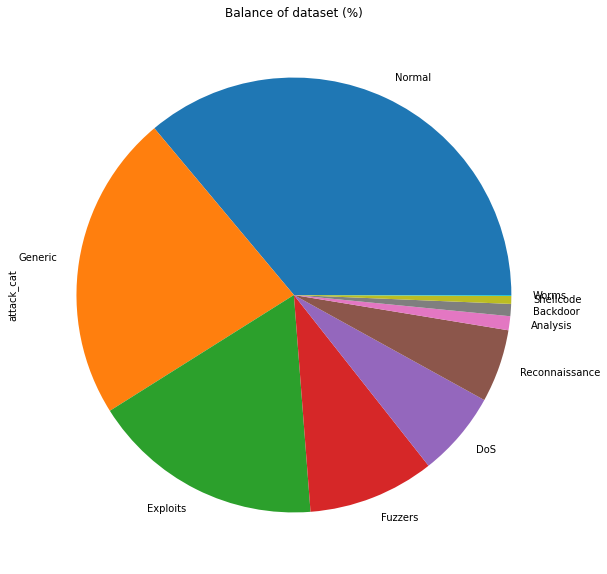

In [0]:
#Visualización en una gráfica circular del peso de cada clase
display(df['attack_cat'].value_counts())
df_plot = (df['attack_cat'].value_counts(normalize=True) *100)
df_plot.plot(kind='pie',figsize=(10,10),title='Balance of dataset (%)')

In [0]:
#Conversión de los datos tipo string a enteros en un rango entre 0 y 255 (1 Byte de información)
def encode_string_byte (df,name):
  df[name] = LabelEncoder().fit_transform(df[name])

encode_string_byte (df,'proto')
encode_string_byte (df,'state') 
encode_string_byte (df,'service') 

display(df.head())
print("")
print("Proto column --> Max value: {} Min value: {} ".format(max(df['proto']),min(df['proto'])))
print("State column --> Max value: {} Min value: {} ".format(max(df['state']),min(df['state'])))
print("Service column --> Max value: {} Min value: {} ".format(max(df['service']),min(df['service'])))

In [0]:
#Normalización de los números enteros en valores decimales en rango entre 0 y 1
def numerical_minmax_normalization (df, name):
  x = df[name].values.reshape(-1,1)
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df[name] = x_scaled

numerical_minmax_normalization(df,'dur')
numerical_minmax_normalization(df,'spkts')
numerical_minmax_normalization(df,'dpkts')
numerical_minmax_normalization(df,'sbytes')
numerical_minmax_normalization(df,'dbytes')
numerical_minmax_normalization(df,'rate')
numerical_minmax_normalization(df,'sttl')
numerical_minmax_normalization(df,'dttl')
numerical_minmax_normalization(df,'sload')
numerical_minmax_normalization(df,'dload')
numerical_minmax_normalization(df,'sloss')
numerical_minmax_normalization(df,'dloss')
numerical_minmax_normalization(df,'sinpkt')
numerical_minmax_normalization(df,'dinpkt')
numerical_minmax_normalization(df,'sjit')
numerical_minmax_normalization(df,'djit')
numerical_minmax_normalization(df,'swin')
numerical_minmax_normalization(df,'stcpb')
numerical_minmax_normalization(df,'dtcpb')
numerical_minmax_normalization(df,'dwin')
numerical_minmax_normalization(df,'tcprtt')
numerical_minmax_normalization(df,'synack')
numerical_minmax_normalization(df,'ackdat')
numerical_minmax_normalization(df,'smean')
numerical_minmax_normalization(df,'dmean')
numerical_minmax_normalization(df,'trans_depth')
numerical_minmax_normalization(df,'response_body_len')
numerical_minmax_normalization(df,'ct_srv_src')
numerical_minmax_normalization(df,'ct_state_ttl')
numerical_minmax_normalization(df,'ct_dst_ltm')
numerical_minmax_normalization(df,'ct_src_dport_ltm')
numerical_minmax_normalization(df,'ct_dst_sport_ltm')
numerical_minmax_normalization(df,'ct_dst_src_ltm')
numerical_minmax_normalization(df,'is_ftp_login')
numerical_minmax_normalization(df,'ct_ftp_cmd')
numerical_minmax_normalization(df,'ct_flw_http_mthd')
numerical_minmax_normalization(df,'ct_src_ltm')
numerical_minmax_normalization(df,'ct_srv_dst')
numerical_minmax_normalization(df,'is_sm_ips_ports')

df.head()

In [0]:
#Mapeo de los valores normalizados del paso anterior a valores enteros entre 0 y 255 (1 Byte de información)
def numerical_split_ohe (df,name):
  pd_to_np = df[name].tolist()
  np_split = []
  
  categories = np.linspace(0, 1, num=256,endpoint=False)
  quantization = range(0,256)

  for value in pd_to_np:
    for i in range(len(categories)-1):
      if (categories[i] <= float(value) <= categories[i+1]):
        np_split.append(quantization[i])
        break
      if (float(value) > categories[-1]):
        np_split.append(quantization[-1])
        break
  
  df[name] = np_split


numerical_split_ohe(df,'dur')
numerical_split_ohe(df,'spkts')
numerical_split_ohe(df,'dpkts')
numerical_split_ohe(df,'sbytes')
numerical_split_ohe(df,'dbytes')
numerical_split_ohe(df,'rate')
numerical_split_ohe(df,'sttl')
numerical_split_ohe(df,'dttl')
numerical_split_ohe(df,'sload')
numerical_split_ohe(df,'dload')
numerical_split_ohe(df,'sloss')
numerical_split_ohe(df,'dloss')
numerical_split_ohe(df,'sinpkt')
numerical_split_ohe(df,'dinpkt')
numerical_split_ohe(df,'sjit')
numerical_split_ohe(df,'djit')
numerical_split_ohe(df,'swin')
numerical_split_ohe(df,'stcpb')
numerical_split_ohe(df,'dtcpb')
numerical_split_ohe(df,'dwin')
numerical_split_ohe(df,'tcprtt')
numerical_split_ohe(df,'synack')
numerical_split_ohe(df,'ackdat')
numerical_split_ohe(df,'smean')
numerical_split_ohe(df,'dmean')
numerical_split_ohe(df,'trans_depth')
numerical_split_ohe(df,'response_body_len')
numerical_split_ohe(df,'ct_srv_src')
numerical_split_ohe(df,'ct_state_ttl')
numerical_split_ohe(df,'ct_dst_ltm')
numerical_split_ohe(df,'ct_src_dport_ltm')
numerical_split_ohe(df,'ct_dst_sport_ltm')
numerical_split_ohe(df,'ct_dst_src_ltm')
numerical_split_ohe(df,'is_ftp_login')
numerical_split_ohe(df,'ct_ftp_cmd')
numerical_split_ohe(df,'ct_flw_http_mthd')
numerical_split_ohe(df,'ct_src_ltm')
numerical_split_ohe(df,'ct_srv_dst')
numerical_split_ohe(df,'is_sm_ips_ports')

display(df.head())

In [0]:
#Quitando la columna attack_cat y guardandola en la variable y.
y_column = df['attack_cat']
df.drop('attack_cat',axis=1,inplace=True)
dummies = pd.get_dummies(y_column) 
y = dummies.values

print(y[:5])
display(dummies.head())

In [0]:
#Padding para que cada fila de datos tenga 64 valores.
byte_images = np.pad(df.to_numpy(), ((0,0),(0,22)), 'constant')

Images for 42 features
Normal Output


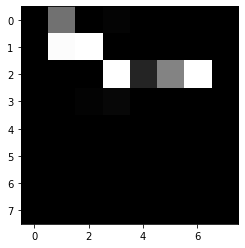

Generic Output


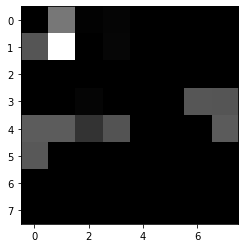

Exploits Output


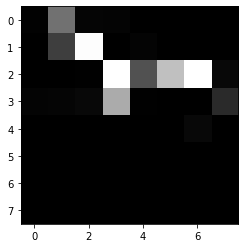

Fuzzers Output


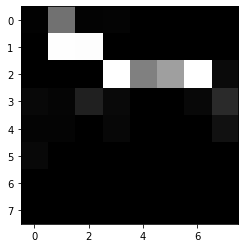

DoS Output


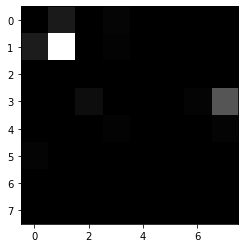

Reconnaissance Output


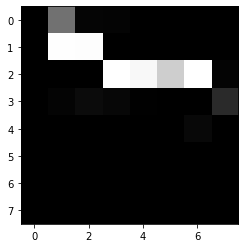

Analysis Output


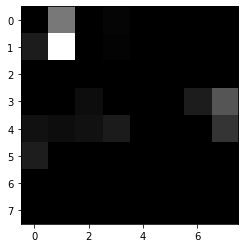

Backdoor Output


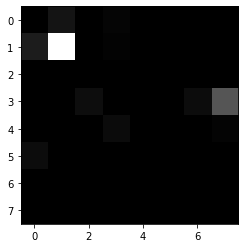

Shellcode Output


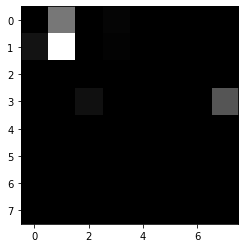

Worms Output


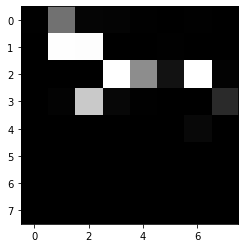

In [0]:
#Tranformación del array 1D en una matriz parar su representación en imagen.
def plot_single_image (byte_image):
  grayImage = byte_image.reshape(8,8)
  plt.imshow(grayImage, cmap="gray")
  plt.show()
print("Images for 42 features")
print("Normal Output")
plot_single_image (byte_images[0])
print("Generic Output")
plot_single_image (byte_images[117204])
print("Exploits Output")
plot_single_image (byte_images[48932])
print("Fuzzers Output")
plot_single_image (byte_images[48017])
print("DoS Output")
plot_single_image (byte_images[48999])
print("Reconnaissance Output")
plot_single_image (byte_images[48866])
print("Analysis Output")
plot_single_image (byte_images[47932])
print("Backdoor Output")
plot_single_image (byte_images[47911])
print("Shellcode Output")
plot_single_image (byte_images[48813])
print("Worms Output")
plot_single_image (byte_images[49959])


In [0]:
#Balanceo del dataset mediante SMOTE (930000 por cada clase) y normalización entre -0,5 y 0,5
x = []
for image in np.array(byte_images):
  x.append((image/255 - 0.5))
sm = SMOTE(random_state=0)
x, y = sm.fit_sample(x, y)
x = np.array(x)
x = x.reshape(x.shape[0],8,8,1)


In [0]:
#Función para representar la curva de precisión por cada hiperparámetro seleccionado.
def plot_accuracies (nets,history,names,y_accuracy):
  plt.figure(figsize=(15,5))
  color = ['red','green','blue','orange','purple','brown','pink','gray','olive','cyan']
  for i in range(nets):
    plt.plot(history[i].history['val_accuracy'],linestyle='--',color = color[i])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(names, loc='upper left')
  axes = plt.gca()
  plt.grid(True)
  axes.set_ylim(y_accuracy)
  plt.show()

In [0]:
#Función de activación Swish
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [0]:
#Separación del dataset en un set de entrenamiento y otro de validación.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(x,y):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Eligiendo el número de bloques VGG.

nets = 3
model = [0] *nets
history = [0] * nets
names = ["1_block_InDeep","2_blocks_InDeep","3_blocks_InDeep"]

epochs = 20
batch_size = 128

for j in range(nets):
  if j == 0 :

    input_img = Input(shape = (8, 8, 1))

    block_1 = BatchNormalization()(input_img)
    block_1 = ReLU()(block_1)
    block_1 = Conv2D(32, (3,3), padding='same')(block_1)
    block_1 = BatchNormalization()(block_1)
    block_1 = ReLU()(block_1)
    block_1 = Conv2D(32, (3,3), padding='same')(block_1)

    output = Flatten()(block_1)
    output = Dense(128, activation='relu')(output)
    out    = Dense(10, activation='softmax')(output)

  if j == 1 :

    input_img = Input(shape = (8, 8, 1))

    block_1 = BatchNormalization()(input_img)
    block_1 = ReLU()(block_1)
    block_1 = Conv2D(32, (3,3), padding='same')(block_1)
    block_1 = BatchNormalization()(block_1)
    block_1 = ReLU()(block_1)
    block_1 = Conv2D(32, (3,3), padding='same')(block_1)

    concat_1 =concatenate([input_img, block_1], axis = 3)

    block_2 = BatchNormalization()(concat_1)
    block_2 = ReLU()(block_2)
    block_2 = Conv2D(64, (3,3), padding='same')(block_2)
    block_2 = BatchNormalization()(block_2)
    block_2 = ReLU()(block_2)
    block_2 = Conv2D(64, (3,3), padding='same')(block_2)

    output = Flatten()(block_2)
    output = Dense(128, activation='relu')(output)
    out    = Dense(10, activation='softmax')(output)

  if j == 2 :

    input_img = Input(shape = (8, 8, 1))

    block_1 = BatchNormalization()(input_img)
    block_1 = ReLU()(block_1)
    block_1 = Conv2D(32, (3,3), padding='same')(block_1)
    block_1 = BatchNormalization()(block_1)
    block_1 = ReLU()(block_1)
    block_1 = Conv2D(32, (3,3), padding='same')(block_1)

    concat_1 =concatenate([input_img, block_1], axis = 3)

    block_2 = BatchNormalization()(concat_1)
    block_2 = ReLU()(block_2)
    block_2 = Conv2D(64, (3,3), padding='same')(block_2)
    block_2 = BatchNormalization()(block_2)
    block_2 = ReLU()(block_2)
    block_2 = Conv2D(64, (3,3), padding='same')(block_2)

    concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

    block_3 = BatchNormalization()(concat_2)
    block_3 = ReLU()(block_3)
    block_3 = Conv2D(128, (3,3), padding='same')(block_3)
    block_3 = BatchNormalization()(block_3)
    block_3 = ReLU()(block_3)
    block_3 = Conv2D(128, (3,3), padding='same',strides=(2,2))(block_3)

    output = Flatten()(block_3)
    output = Dense(128, activation='relu')(output)
    out    = Dense(10, activation='softmax')(output)

  model[j] = Model(inputs = input_img, outputs = out)
  model[j].summary()
  model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  history[j] = model[j].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  score = model[j].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN: {}, Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[j],epochs,batch_size,score[0],score[1]))
  print ("")

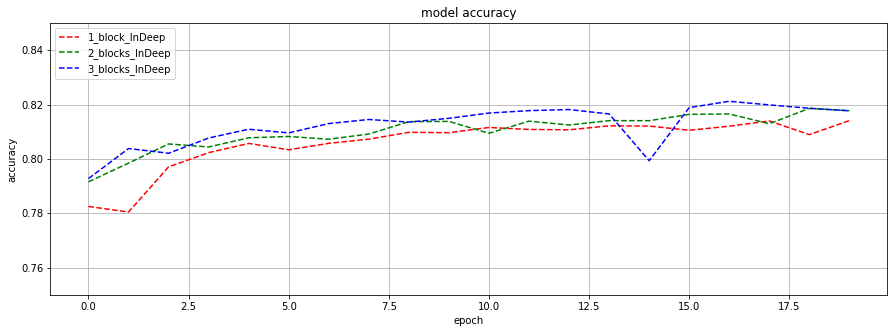

In [0]:
plot_accuracies (nets,history,names,[0.75,0.85])
#Número de bloques elegidos ---> 3

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Eligiendo el número de filtros.

nets = 6
model = [0] *nets
history = [0] * nets
names = ["8 maps","16 maps","24 maps","32 maps","48 maps","64 maps"]

epochs = 20
batch_size = 128


for j in range(nets):

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = ReLU()(block_1)
  block_1 = Conv2D(j*8+8, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = ReLU()(block_1)
  block_1 = Conv2D(j*8+8, (3,3), padding='same')(block_1)

  concat_1 =concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = ReLU()(block_2)
  block_2 = Conv2D(j*16+16, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = ReLU()(block_2)
  block_2 = Conv2D(j*16+16, (3,3), padding='same')(block_2)

  concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = ReLU()(block_3)
  block_3 = Conv2D(j*32+32, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = ReLU()(block_3)
  block_3 = Conv2D(j*32+32, (3,3), padding='same',strides=(2,2))(block_3)

  output = Flatten()(block_3)
  output = Dense(128, activation='relu')(output)
  out    = Dense(10, activation='softmax')(output)
  
  model[j] = Model(inputs = input_img, outputs = out)
  model[j].summary()
  model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  history[j] = model[j].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  score = model[j].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN {}: Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[j],epochs,batch_size,score[0],score[1]))
  print ("")

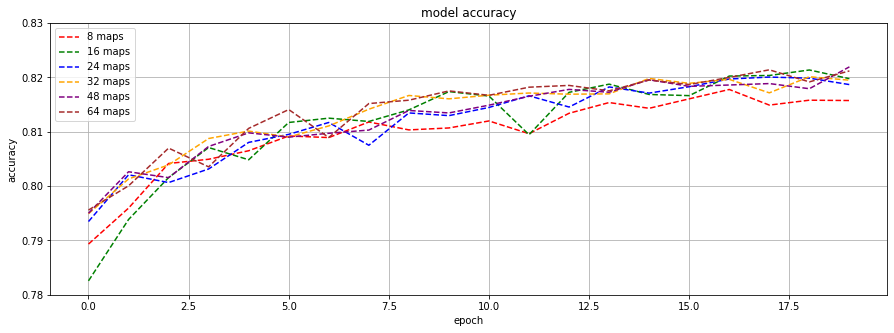

In [0]:
plot_accuracies (nets,history,names,[0.78,0.83])
#Número de filtros elegidos ---> 16 filtros

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Eligiendo el número de capas densas.

nets = 4
model = [0] *nets
history = [0] * nets
names = ["1_dense_layer","2_dense_layer","3_dense_layer","4_dense_layer"]

epochs = 50
batch_size = 128


for j in range(nets):

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = ReLU()(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = ReLU()(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)

  concat_1 =concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = ReLU()(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = ReLU()(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)

  concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = ReLU()(block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = ReLU()(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)

  output = Flatten()(block_3)

  if j == 0:
    out    = Dense(10, activation='softmax')(output)
  if j == 1:
    output = Dense(128, activation='relu')(output)
    out    = Dense(10, activation='softmax')(output)
  if j == 2:
    output = Dense(256, activation='relu')(output)
    output = Dense(128, activation='relu')(output)
    out    = Dense(10, activation='softmax')(output)
  if j == 3:
    output = Dense(512, activation='relu')(output)
    output = Dense(256, activation='relu')(output)
    output = Dense(128, activation='relu')(output)
    out    = Dense(10, activation='softmax')(output)
  
  model[j] = Model(inputs = input_img, outputs = out)
  model[j].summary()
  model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  history[j] = model[j].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  score = model[j].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN {}: Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[j],epochs,batch_size,score[0],score[1]))
  print ("")

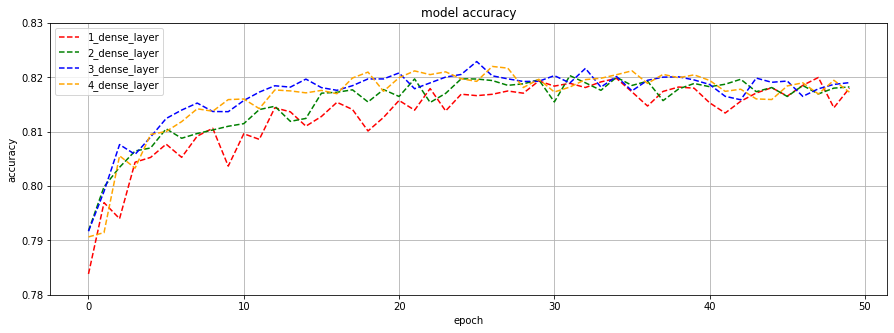

In [0]:
plot_accuracies (nets,history,names,[0.78,0.83])
#Número de capas densas ---> 3.

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Eligiendo el número de neuronas por capa densa.

nets = 7
model = [0] *nets
history = [0] * nets
names = ["32N","64N","128N","256N","512N","1024N","2048N"]

epochs = 50
batch_size = 128


for j in range(nets):

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = ReLU()(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = ReLU()(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)

  concat_1 =concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = ReLU()(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = ReLU()(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)

  concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = ReLU()(block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = ReLU()(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)

  output = Flatten()(block_3)
  output = Dense(2**(j+5), activation='relu')(output)
  output = Dense((2**(j+5))/2, activation='relu')(output)
  out    = Dense(10, activation='softmax')(output)

  model[j] = Model(inputs = input_img, outputs = out)
  model[j].summary()
  model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  history[j] = model[j].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  score = model[j].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN {}: Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[j],epochs,batch_size,score[0],score[1]))
  print ("")

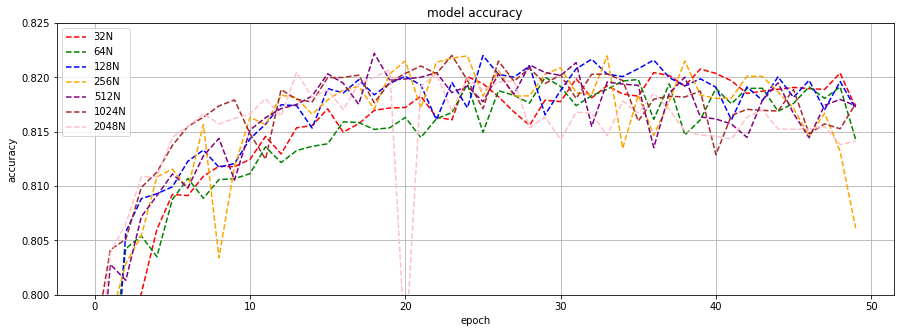

In [0]:
plot_accuracies (nets,history,names,[0.80,0.825])
#Número de neuronas elegidas ---> 128  

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Eligiendo la función de activación.

nets = 3
model = [0] *nets
history = [0] * nets
names = ["ReLu","Leaky_ReLu","Swish"]
functions = [ReLU(),LeakyReLU(alpha=0.01),Activation(swish)]

epochs = 50
batch_size = 128

for j in range(nets):

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = functions[j](block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = functions[j](block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)

  concat_1 =concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = functions[j](block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = functions[j](block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)

  concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = functions[j](block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = functions[j](block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)

  output = Flatten()(block_3)
  output = Dense(128, activation=functions[j])(output)
  output = Dense(64, activation=functions[j])(output)
  out    = Dense(10, activation='softmax')(output)

  model[j] = Model(inputs = input_img, outputs = out)
  model[j].summary()
  model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  history[j] = model[j].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  score = model[j].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN {}: Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[j],epochs,batch_size,score[0],score[1]))
  print ("")


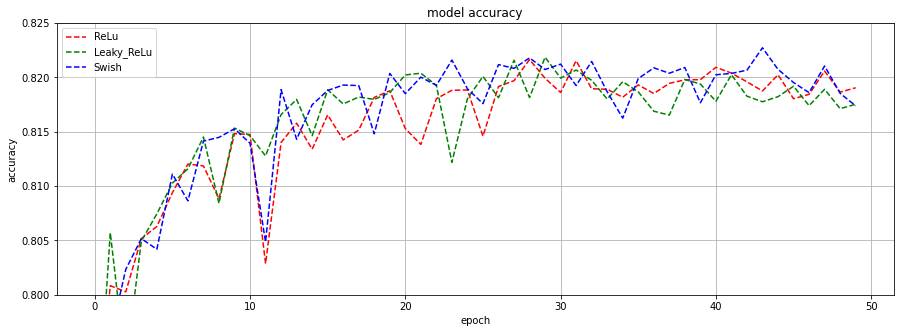

In [0]:
plot_accuracies (nets,history,names,[0.80,0.825])
#Función de activación elegida ---> Swish    

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Eligiendo el tamaño del batch.

nets = 6
model = [0] *nets
history = [0] * nets
names = ["32 Batch_size","64 Batch_size","128 Batch_size","256 Batch_size","512 Batch_size","1024 Batch_size"]

epochs = 50

for j in range(nets):

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)

  concat_1 =concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)

  concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)

  output = Flatten()(block_3)
  output = Dense(128, activation=Activation(swish))(output)
  output = Dense(64, activation=Activation(swish))(output)
  out    = Dense(10, activation='softmax')(output)

  model[j] = Model(inputs = input_img, outputs = out)
  model[j].summary()
  model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  history[j] = model[j].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=2**(j+5),epochs=epochs)

  score = model[j].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN {}: Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[j],epochs,2**(j+5),score[0],score[1]))
  print ("")

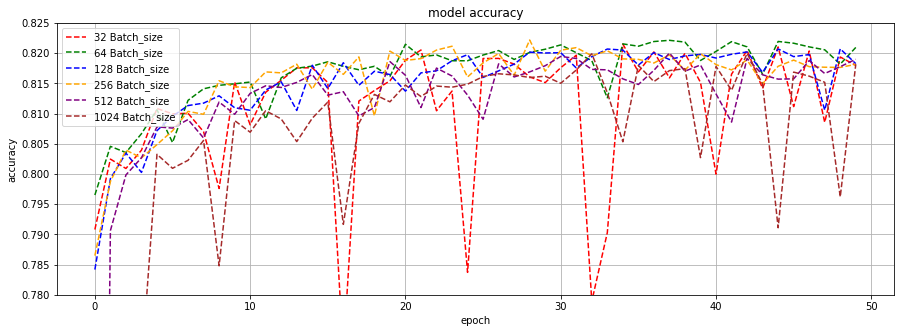

In [0]:
plot_accuracies (nets,history,names,[0.78,0.825])
#Tamaño del bacth elegido ---> 512

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Eligiendo la probabilidad de descarte del dropout en las capas convolucionales.

nets = 8
model = [0] *nets 
history = [0] * nets
names = ["0%","10%","20%","30%","40%","50%","60%","70%"]

epochs = 50
batch_size = 512

for j in range(nets):

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = Dropout(rate=j*0.1)(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = Dropout(rate=j*0.1)(block_1)

  concat_1 = concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = Dropout(rate=j*0.1)(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = Dropout(rate=j*0.1)(block_2)

  concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = Dropout(rate=j*0.1)(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)
  block_3 = Dropout(rate=j*0.1)(block_3)

  output = Flatten()(block_3)
  output = Dense(128, activation=Activation(swish))(output)
  output = Dense(64, activation=Activation(swish))(output)
  out    = Dense(10, activation='softmax')(output)

  model[j] = Model(inputs = input_img, outputs = out)
  model[j].summary()
  model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  history[j] = model[j].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  score = model[j].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN {}: Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[j],epochs,batch_size,score[0],score[1]))
  print ("")

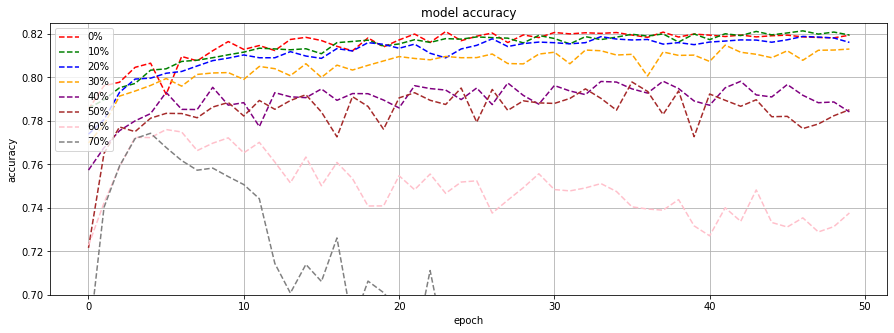

In [0]:
plot_accuracies (nets,history,names,[0.70,0.825])
#Probabilidad de desacarte elegido ---> 0%       

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Eligiendo la probabilidad de descarte del dropout en las capas densas.

nets = 8
model = [0] *nets 
history = [0] * nets
names = ["0%","10%","20%","30%","40%","50%","60%","70%"]

epochs = 50
batch_size = 512

for j in range(nets):

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)

  concat_1 =concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)

  concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)

  output = Flatten()(block_3)
  output = Dense(128, activation=Activation(swish))(output)
  output = Dropout(rate=j*0.1)(output)
  output = Dense(64, activation=Activation(swish))(output)
  output = Dropout(rate=j*0.1)(output)
  out    = Dense(10, activation='softmax')(output)

  model[j] = Model(inputs = input_img, outputs = out)
  model[j].summary()
  model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  history[j] = model[j].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  score = model[j].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN {}: Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[j],epochs,batch_size,score[0],score[1]))
  print ("")

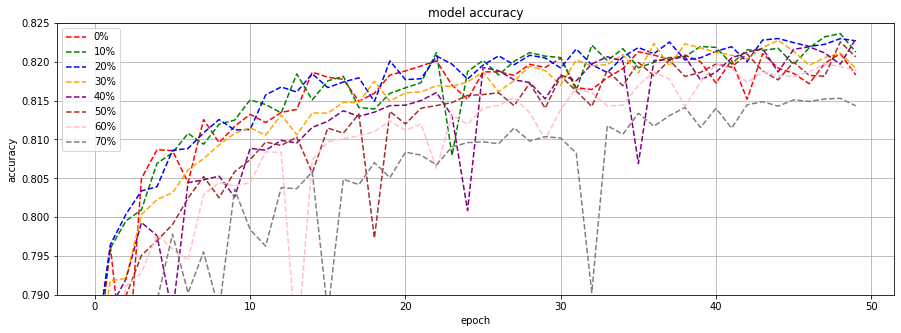

In [0]:
plot_accuracies (nets,history,names,[0.79,0.825])
#Probabilidad de descarte elegida ---> 20%

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Eligiendo λ para el optimizador L1.

nets = 5
model = [0] *nets
history = [0] * nets
names = ["1e-1","1e-2","1e-3","1e-4","1e-5"]

epochs = 50
batch_size = 512

for j in range(nets):

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same',activity_regularizer=l1(0.1/(10**j)))(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same',activity_regularizer=l1(0.1/(10**j)))(block_1)

  concat_1 =concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same',activity_regularizer=l1(0.1/(10**j)))(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same',activity_regularizer=l1(0.1/(10**j)))(block_2)

  concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',activity_regularizer=l1(0.1/(10**j)))(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2),activity_regularizer=l1(0.1/(10**j)))(block_3)

  output = Flatten()(block_3)
  output = Dense(128, activation=Activation(swish),activity_regularizer=l1(0.1/(10**j)))(output)
  output = Dropout(rate=0.2)(output)
  output = Dense(64, activation=Activation(swish),activity_regularizer=l1(0.1/(10**j)))(output)
  output = Dropout(rate=0.2)(output)
  out    = Dense(10, activation='softmax',activity_regularizer=l1(0.1/(10**j)))(output)

  model[j] = Model(inputs = input_img, outputs = out)
  model[j].summary()
  model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  history[j] = model[j].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  score = model[j].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN {}: Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[j],epochs,batch_size,score[0],score[1]))
  print ("")


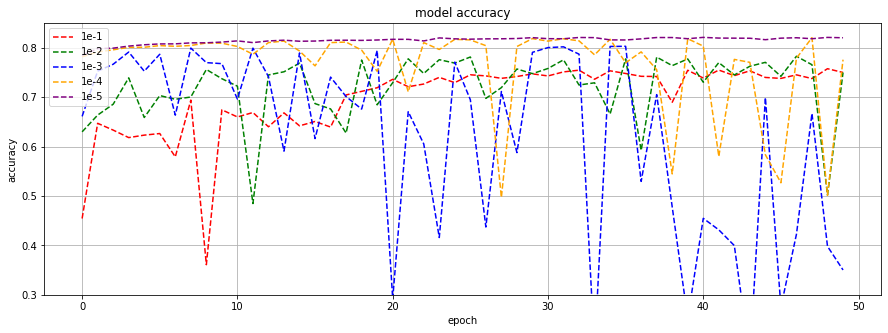

In [0]:
plot_accuracies (nets,history,names,[0.30,0.85])
#λ elegida --->  null  

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Eligiendo optimizador.

nets = 7
model = [0] *nets
history = [0] * nets
names = ["sgd","rmsprop","adagrad","adadelta","adam","adamax","nadam"]

epochs = 50
batch_size = 512

for j in range(nets):

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)

  concat_1 =concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)

  concat_2 =concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)

  output = Flatten()(block_3)
  output = Dense(128, activation=Activation(swish))(output)
  output = Dropout(rate=0.2)(output)
  output = Dense(64, activation=Activation(swish))(output)
  output = Dropout(rate=0.2)(output)
  out    = Dense(10, activation='softmax')(output)

  model[j] = Model(inputs = input_img, outputs = out)
  model[j].summary()
  model[j].compile(optimizer=names[j], loss="categorical_crossentropy", metrics=["accuracy"])
  history[j] = model[j].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  score = model[j].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN {}: Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[j],epochs,batch_size,score[0],score[1]))
  print ("")


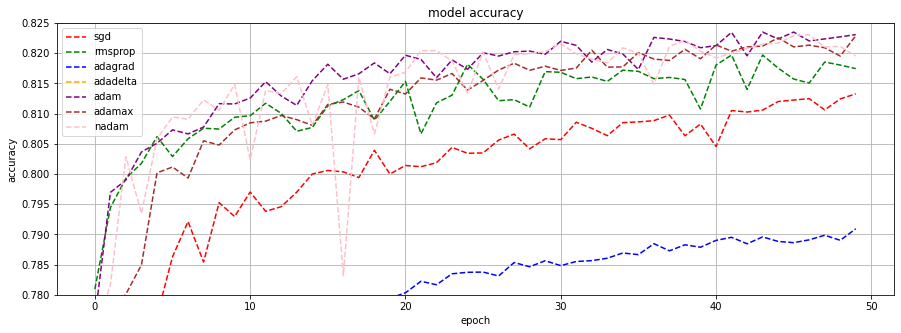

In [0]:
plot_accuracies (nets,history,names,[0.78,0.825])
#Optimizador elegido ---> Adam

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Eligiendo la tasa de aprendizaje.

nets = 6
model = [0] *nets
history = [0] * nets
names = ["1e-2","1e-3","1e-4","1e-5","1e-6","1e-7"]

epochs = 50
batch_size = 512

for j in range(nets):

  lr = 0.01*(10**-j)
  opt = Adam(lr=lr)

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)

  concat_1 = concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)

  concat_2 = concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)

  output = Flatten()(block_3)
  output = Dense(128, activation=Activation(swish))(output)
  output = Dropout(rate=0.2)(output)
  output = Dense(64, activation=Activation(swish))(output)
  output = Dropout(rate=0.2)(output)
  out    = Dense(10, activation='softmax')(output)

  model[j] = Model(inputs = input_img, outputs = out)
  model[j].summary()
  model[j].compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
  history[j] = model[j].fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  score = model[j].evaluate(x_test, y_test, verbose=0)
  print ("")
  print("CNN {}: Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}".format(names[j],epochs,batch_size,score[0],score[1]))
  print ("")

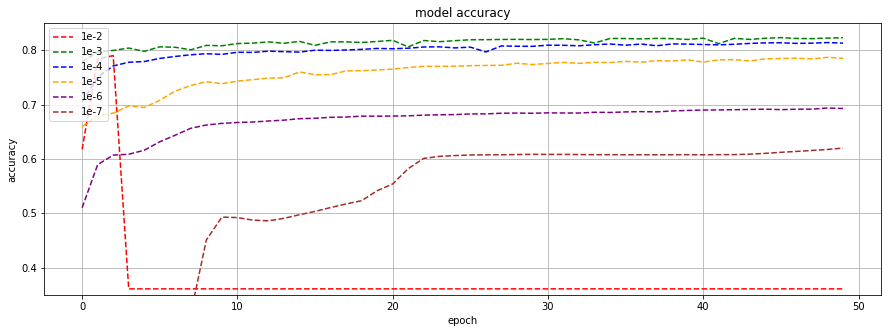

In [0]:
plot_accuracies (nets,history,names,[0.35,0.85])
#Tasa de aprendizaje elegida ---> 1e-3. No se usa despues ya que Adam actualiza este parámetro automáticamente.

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Defininción del modelo para la optimización bayesiana.

def get_model(dropout_rate,dense1,dense2):

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)

  concat_1 = concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)

  concat_2 = concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)

  output = Flatten()(block_3)
  output = Dense(dense1, activation=Activation(swish))(output)
  output = Dropout(rate=dropout_rate)(output)
  output = Dense(dense2, activation=Activation(swish))(output)
  output = Dropout(rate=dropout_rate)(output)
  out    = Dense(10, activation='softmax')(output)

  model = Model(inputs = input_img, outputs = out)

  return model   

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Optimización bayesiana.
def evaluate_network(dropout_rate,dense1,dense2,lr):
  model = get_model(dropout_rate,dense1,dense2)
  model.compile(optimizer=Adam(lr=lr), loss="categorical_crossentropy", metrics=["accuracy"])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,batch_size=256,epochs=20)
  score = model.evaluate(x_test, y_test, verbose=0)
  return score[1] 

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Optimización bayesiana.

pbounds = {'dropout_rate': (0.1, 0.3), 'lr': (1e-4, 1e-2), 'dense1':(64,256), 'dense2':(32,128)}

optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=40,)
print(optimizer.max)           

|   iter    |  target   |  dense1   |  dense2   | dropou... |    lr     |
-------------------------------------------------------------------------
|  1        |  0.8117   |  144.1    |  101.2    |  0.1      |  0.003093 |
|  2        |  0.8127   |  92.18    |  40.86    |  0.1373   |  0.003521 |
|  3        |  0.3609   |  140.2    |  83.73    |  0.1838   |  0.006884 |
|  4        |  0.81     |  103.3    |  116.3    |  0.1055   |  0.006738 |
|  5        |  0.8146   |  144.1    |  85.63    |  0.1281   |  0.002061 |
|  6        |  0.4465   |  217.7    |  125.0    |  0.1627   |  0.006954 |
|  7        |  0.8121   |  232.3    |  117.9    |  0.117    |  0.000486 |
|  8        |  0.8148   |  96.61    |  116.3    |  0.1197   |  0.004269 |
|  9        |  0.814    |  247.9    |  83.18    |  0.2384   |  0.003224 |
|  10       |  0.4486   |  195.8    |  112.1    |  0.1037   |  0.007526 |
|  11       |  0.8138   |  144.6    |  85.6     |  0.1959   |  0.004069 |
|  12       |  0.4608   |  64.0     | 

In [0]:
#DISEÑO DE LA RED NEURONAL CONVOLUCIONAL -- Validación cruzada.

epochs = 50
batch_size =512

kf = StratifiedKFold(10, shuffle=True, random_state=42)

oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(x,y_column): # Must specify y StratifiedKFold for 
  fold+=1
  print(f"Fold #{fold}")
      
  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)

  concat_1 = concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)

  concat_2 = concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)

  output = Flatten()(block_3)
  output = Dense(128, activation=Activation(swish))(output)
  output = Dropout(rate=0.2)(output)
  output = Dense(64, activation=Activation(swish))(output)
  output = Dropout(rate=0.2)(output)
  out    = Dense(10, activation='softmax')(output)

  model = Model(inputs = input_img, outputs = out)
  model.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=batch_size,epochs=epochs)

  pred = model.predict(x_test)

  oos_y.append(y_test)
  pred = np.argmax(pred,axis=1) 
  oos_pred.append(pred)  

  y_compare = np.argmax(y_test,axis=1) 
  score = metrics.accuracy_score(y_compare, pred)
  print(f"Fold score (accuracy): {score}")

oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) 

score = metrics.accuracy_score(oos_y_compare, oos_pred)
print(f"Final score (accuracy): {score}") 


In [0]:
#Definición del modelo final.
def InDeep_model():

  input_img = Input(shape = (8, 8, 1))

  block_1 = BatchNormalization()(input_img)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)
  block_1 = BatchNormalization()(block_1)
  block_1 = Activation(swish)(block_1)
  block_1 = Conv2D(16, (3,3), padding='same')(block_1)

  concat_1 = concatenate([input_img, block_1], axis = 3)

  block_2 = BatchNormalization()(concat_1)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)
  block_2 = BatchNormalization()(block_2)
  block_2 = Activation(swish)(block_2)
  block_2 = Conv2D(32, (3,3), padding='same')(block_2)

  concat_2 = concatenate([input_img, block_1,block_2], axis = 3)

  block_3 = BatchNormalization()(concat_2)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same')(block_3)
  block_3 = BatchNormalization()(block_3)
  block_3 = Activation(swish)(block_3)
  block_3 = Conv2D(64, (3,3), padding='same',strides=(2,2))(block_3)

  output = Flatten()(block_3)
  output = Dense(128, activation=Activation(swish))(output)
  output = Dropout(rate=0.2)(output)
  output = Dense(64, activation=Activation(swish))(output)
  output = Dropout(rate=0.2)(output)
  out    = Dense(10, activation='softmax')(output)

  model = Model(inputs = input_img, outputs = out)
  model.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

  return model

In [0]:
#Proceso de entrenamiento
model = InDeep_model()
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, min_delta=0.001, patience=25, restore_best_weights=False)
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,batch_size=512,epochs=200,callbacks=[es])

In [0]:
#Predicciones de la red entrenada, medidad con Accuracy, precision, reacall y F1.
y_pred = model.predict(x)
y_pred = np.argmax(y_pred,axis=1) 
y_true = np.argmax(y,axis=1)

print("Accuracy: {}" .format(metrics.accuracy_score(y_true, y_pred)))
print("Precision: {}" .format(metrics.precision_score(y_true, y_pred, average='macro')))
print("Recall: {}" .format(metrics.recall_score(y_true, y_pred, average='macro')))
print("F1: {}" .format(metrics.f1_score(y_true, y_pred, average='macro')))


In [0]:
#Función para representar la matriz de confusión.
def plot_confusing_matrix (y_ture,y_pred,n_categories,outcome_labels):

  cm = metrics.confusion_matrix(y_true, y_pred, labels = list(range(n_categories)))
  plot_confusion_matrix(conf_mat=cm,figsize=(13,13),class_names = outcome_labels,show_normed=True)
  plt.title('Confusing Matrix')
  plt.ylabel('Target')
  plt.xlabel('Predicted')
  plt.show()

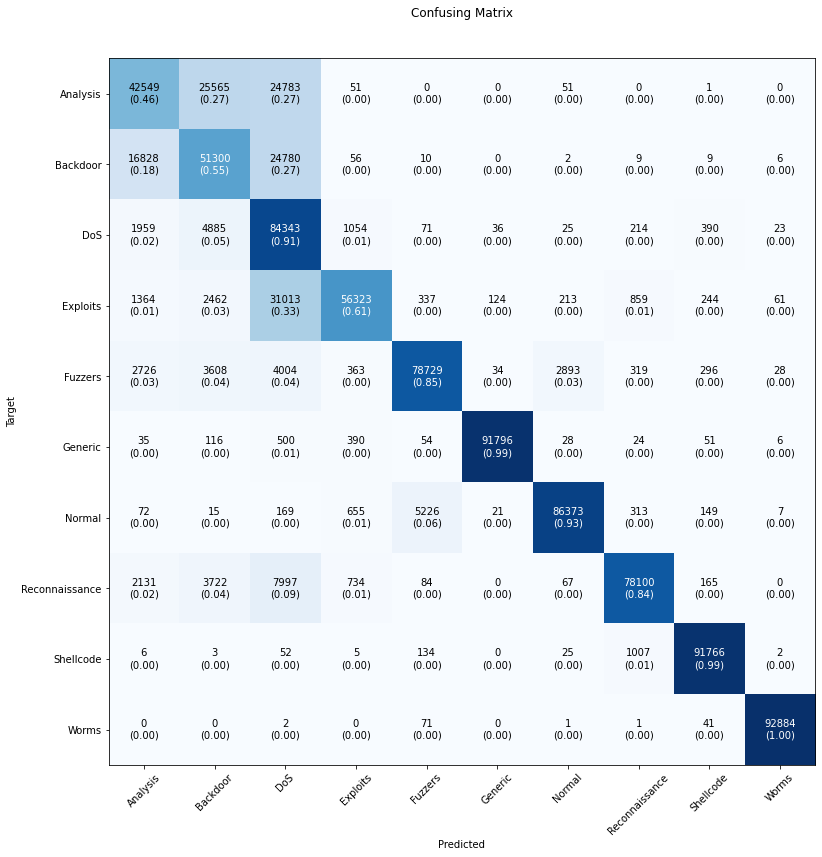

In [0]:
#Matriz de confusión.
outcome_labels = ["Analysis", "Backdoor",	"DoS", "Exploits", "Fuzzers", "Generic","Normal", "Reconnaissance","Shellcode", "Worms"]
plot_confusing_matrix(y_true,y_pred,10,outcome_labels)

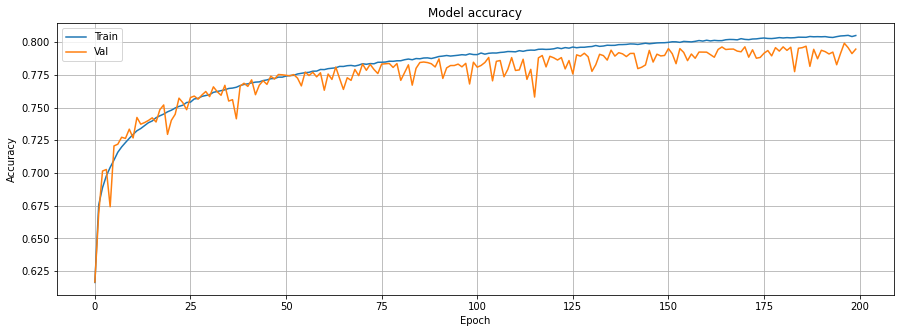

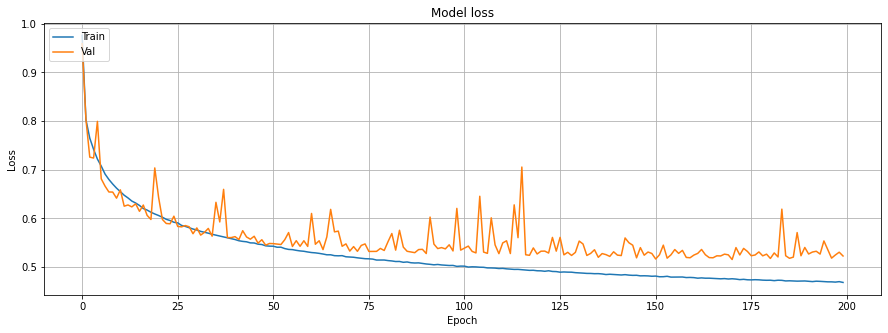

In [0]:
#Representación de las curvas de aprendizaje
def model_accuracy_loss(history):

  plt.rcParams["figure.figsize"] = (15,5)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','Val'],loc = 'upper left')
  plt.grid(True)
  plt.show()

  plt.rcParams["figure.figsize"] = (15,5)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train','Val'],loc = 'upper left')
  plt.grid(True)
  plt.show()

model_accuracy_loss(history)